In [1]:
import multiprocessing as mp
import pykonal
import scipy.spatial
import tqdm.notebook as tqdm

# 1. Build synthetic data
## 1.1. Build true velocity model

In [2]:
vmodel_true = pykonal.fields.ScalarField3D(coord_sys="cartesian")
vmodel_true.min_coords     =   0, -10, 0
vmodel_true.node_intervals =   5,   5, 1
vmodel_true.npts           = 461, 203, 1


vv = pd.read_csv("vmodel.txt")
vmodel_true.values = np.interp(vmodel_true.nodes[..., 1], vv["depth"], vv["vs"]*1.9)
# depth = vmodel.nodes[..., 1]
# vmodel.values = 3700 + (depth-50)
# # Set v=1500 m/s for the top 50 m
# vmodel.values[vmodel.nodes[..., 1] <= 50] = 1500

## 1.2. Define source/receiver geometry

In [3]:
nrx = 76 # Number of receivers
nsx = 36 # Number of sources
dx = vmodel_true.max_coords[0] - vmodel_true.min_coords[0]
drx = dx / nrx
dsx = dx / nsx
rxs = np.arange(drx/2, vmodel_true.max_coords[0], drx) # Receiver offsets
sxs = np.arange(dsx/2, vmodel_true.max_coords[0], dsx) # Source offests

### Plot geometry

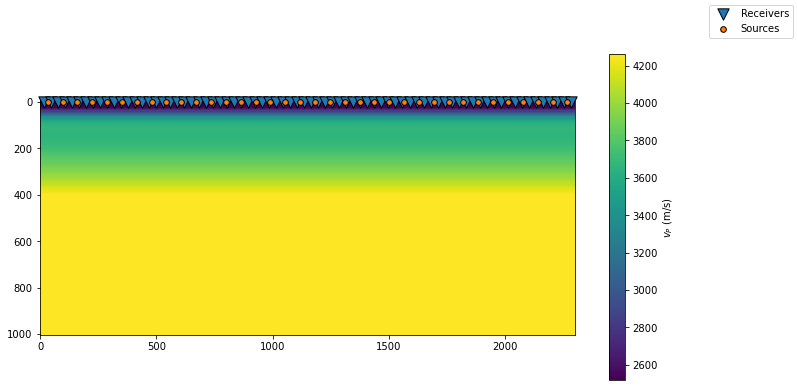

In [4]:
plt.close("all")
fig, ax = plt.subplots(figsize=(12, 6))
qmesh = ax.pcolormesh(
    vmodel_true.nodes[:, :, 0, 0],
    vmodel_true.nodes[:, :, 0, 1],
    vmodel_true.values[:, :, 0]
)
ax.scatter(rxs, np.zeros_like(rxs), marker="v", clip_on=False, s=128, edgecolor="k", zorder=100, label="Receivers")
ax.scatter(sxs, np.zeros_like(sxs), marker="o", clip_on=False, s=32, edgecolor="k", zorder=100, label="Sources")
ax.set_aspect(1)
ax.invert_yaxis()
fig.legend()

cbar = fig.colorbar(qmesh, ax=ax)
cbar.set_label("$v_P$ (m/s)")

# Define some convenience functions for wavefront propagation

In [5]:
def sph2xyz(rtp, x0=0, y0=0):
    x = x0 + rtp[..., 0] * np.cos(rtp[..., 2])
    y = y0 + rtp[..., 0] * np.sin(rtp[..., 2])
    xyz = np.stack([x, y, np.zeros_like(x)], axis=-1)
    return (xyz)

def xyz2sph(xyz, x0=0, y0=0):
    dx = xyz[..., 0] - x0
    dy = xyz[..., 1] - y0
    r = np.sqrt(np.square(dx) + np.square(dy))
    p = np.arctan2(dy, dx)
    rtp = np.stack([r, np.pi/2 * np.ones_like(r), p], axis=-1)
    return (rtp)

def propagate_wavefront(src, vmodel):
    # Define the far-field grid
    ff = pykonal.EikonalSolver(coord_sys="cartesian")
    ff.vv.min_coords = vmodel.min_coords
    ff.vv.node_intervals = vmodel.node_intervals
    ff.vv.npts = vmodel.npts
    ff.vv.values = vmodel.values

    # Define a near-field grid centered on the source location
    nf = pykonal.EikonalSolver(coord_sys="spherical")
    nf.vv.min_coords = 1, np.pi/2, 0
    nf.vv.node_intervals = 10, 1, np.pi/31
    nf.vv.npts = 50, 1, 32

    # Interpolate velocity from the far-field grid to the near-field grid
    xyz = sph2xyz(nf.vv.nodes, x0=src[0], y0=src[1])
    nf.vv.values = ff.vv.resample(xyz.reshape(-1, 3)).reshape(xyz.shape[:-1])

    # Initialize the near-field narrow-band
    for ip in range(nf.tt.npts[2]):
        idx = (0, 0, ip)
        vv = nf.vv.values[idx]
        if not np.isnan(vv):
            nf.tt.values[idx] = nf.tt.node_intervals[0] / vv
            nf.unknown[idx] = False
            nf.trial.push(*idx)

    # Propagate the wavefront across the near-field grid
    nf.solve()

    # Map the traveltime values from the near-field grid onto the far-field grid
    rtp = xyz2sph(ff.tt.nodes, x0=src[0], y0=src[1])
    rtp = rtp.reshape(-1, 3)
    tt = nf.tt.resample(rtp)
    tt = tt.reshape(ff.tt.npts)

    idxs = np.nonzero(np.isnan(tt))
    tt[idxs] = np.inf

    ff.tt.values = tt

    # Initialize far-field narrow band
    for idx in np.argwhere(~np.isinf(ff.tt.values)):
        idx = tuple(idx)
        ff.unknown[idx] = False
        ff.trial.push(*idx)

    # Propagate the wavefront across the remainder of the far field.
    ff.solve()
    
    return (ff)

In [6]:
dataf_true = pd.DataFrame(columns=["sxid", "rxid", "tt"])

for sxid, sx in enumerate(sxs):
    src = (sx, 0, 0)
    ff = propagate_wavefront(src, vmodel_true)
    tt = ff.tt.resample(np.stack([rxs, np.zeros_like(rxs), np.zeros_like(rxs)], axis=1))
    dataf_true = pd.concat(
        [
            dataf_true,
            pd.DataFrame(
                dict(
                    sxid=sxid+1,
                    rxid=np.arange(1, nrx+1),
                    tt=tt
                )
            ),
        ],
        ignore_index=True
    )

dataf_true = dataf_true.astype(dict(sxid=int, rxid=int, tt=float))

# Demonstrate ray tracing

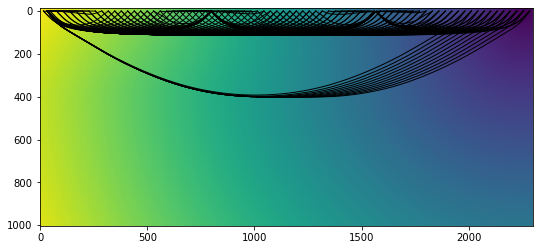

In [87]:
plt.close("all")
fig, ax = plt.subplots(figsize=(12, 4))
ax.pcolormesh(ff.tt.nodes[:, :, 0, 0], ff.tt.nodes[:, :, 0, 1], ff.tt.values[:, :, 0])
for sx in sxs[::12]:
    src = (sx, 0, 0)
    for rx in rxs:
        ff = propagate_wavefront(src, vmodel_true)
        ray = ff.trace_ray(np.array([rx, 0, 0]))
        ax.plot(ray[:, 0], ray[:, 1], color="k", linewidth=1)
ax.invert_yaxis()
ax.set_aspect(1)

# Invert for velocity structure
## Create initial model

In [16]:
(vmodel_true.values.max() - vmodel_true.values.min()) / 1000

1.7435115629752391

In [104]:
vmodel = pykonal.fields.ScalarField3D(coord_sys="cartesian")
vmodel.min_coords     =   0, -10, 0
vmodel.node_intervals =   5,   5, 1
vmodel.npts           = 461, 203, 1


vv = pd.read_csv("vmodel.txt")
vmodel.values = 2500 + vmodel.nodes[..., 1] * 1.75

## Plot initial model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


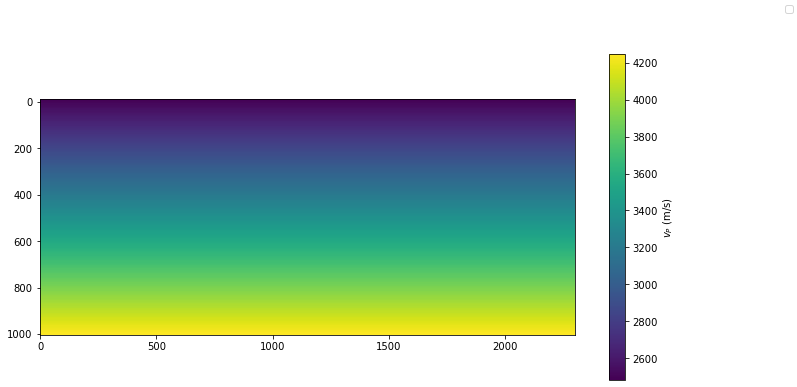

In [105]:
plt.close("all")
fig, ax = plt.subplots(figsize=(12, 6))
qmesh = ax.pcolormesh(
    vmodel.nodes[:, :, 0, 0],
    vmodel.nodes[:, :, 0, 1],
    vmodel.values[:, :, 0]
)
ax.set_aspect(1)
ax.invert_yaxis()
fig.legend()

cbar = fig.colorbar(qmesh, ax=ax)
cbar.set_label("$v_P$ (m/s)")

## Generate "observed" data by adding noise to true data

In [106]:
dataf_obs = dataf_true
dataf_obs["tt"] += np.random.choice((-1, 1), size=len(dataf_obs)) \
    * np.random.rand(len(dataf_obs)) \
    * dataf_obs["tt"] \
    * 0.05

In [107]:
def random_realization(args):
    
    nvoronoi, frac, dataf_obs, seed = args
    np.random.seed(seed)

    ########################
    # Randomly sample data #
    ########################
    dataf = dataf_obs.sample(frac=frac, random_state=seed)
    dataf = dataf.sort_values(["sxid", "rxid"])
    
    ##########################
    # Generate Voronoi cells #
    ##########################
    delta = vmodel.max_coords - vmodel.min_coords
    vcells = vmodel.min_coords + np.random.rand(nvoronoi, 3) * delta
    tree = scipy.spatial.cKDTree(vcells[:, :2])
    
    ###############################
    # Compute projection matrix P #
    ###############################
    nnodes = np.prod(vmodel.nodes.shape[:-1])
    row_idxs = np.arange(nnodes)
    _, column_idxs = tree.query(vmodel.nodes[:, :, 0, :2].reshape(-1, 2))

    values = np.ones(nnodes,)
    P = scipy.sparse.coo_matrix(
        (values, (row_idxs, column_idxs)),
        shape=(nnodes, tree.n)
    )
    
    ################################
    # Compute sensitivity matrix G #
    ################################
    column_idxs = np.array([], dtype=np.int32)
    nsegments = np.array([], dtype=np.int32)
    nonzero_values = np.array([], dtype=np.float64)
    residuals = np.array([], dtype=np.float64)

    for sxid in tqdm.tqdm(dataf["sxid"].unique()):
        sx = sxs[sxid-1]
        ff = propagate_wavefront((sx, 0, 0), vmodel)
        for _, (rxid, tt) in dataf.set_index("sxid").loc[sxid].iterrows():
            rx = rxs[int(rxid)-1]
            residual = tt - ff.tt.resample(np.array([[rx, 0, 0]]))[0] # observed - synthetic
            ray = ff.trace_ray(np.array([rx, 0, 0]))
            _, _column_idxs = tree.query(ray[:, :2])
            _column_idxs, counts = np.unique(_column_idxs, return_counts=True)
            column_idxs = np.append(column_idxs, _column_idxs)
            nsegments = np.append(nsegments, len(_column_idxs))
            nonzero_values = np.append(nonzero_values, counts * ff.tt.step_size)
            residuals = np.append(residuals, residual)

    row_idxs = np.array([
        i for i in range(len(nsegments)) for j in range(nsegments[i])
    ])

    G = scipy.sparse.coo_matrix(
        (nonzero_values, (row_idxs, column_idxs)),
        shape=(len(nsegments), nvoronoi)
    )
    
    
    ##########################
    # Solve for model update #
    ##########################
    
    # Parameters of LSMR solver 
    damp = 1
    atol = 1e-3
    btol = 1e-4
    conlim = 50
    maxiter = 100

    x, istop, itn, normr, normar, norma, conda, normx = scipy.sparse.linalg.lsmr(
        G,
        residuals,
        damp,
        atol,
        btol,
        conlim,
        maxiter,
        show=False
    )

    delta_slowness = P * x
    delta_slowness = delta_slowness.reshape(vmodel.npts)
    slowness = np.power(vmodel.values, -1) + delta_slowness
    velocity = np.power(slowness, -1)
    
    return (velocity)

In [108]:
nvoronoi = 128
frac     = 0.5
nreal    = 128
niter    = 16

models = [vmodel.values.copy()]

for iiter in range(niter):
    print(iiter)
    with mp.Pool() as pool:
        vvs = pool.map(
            random_realization,
            ((nvoronoi, frac, dataf_obs, seed) for seed in np.random.randint(0, 2147483647, size=nreal))
        )
    vmodel.values = np.median(np.stack(vvs), axis=0)
    models.append(vmodel.values.copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


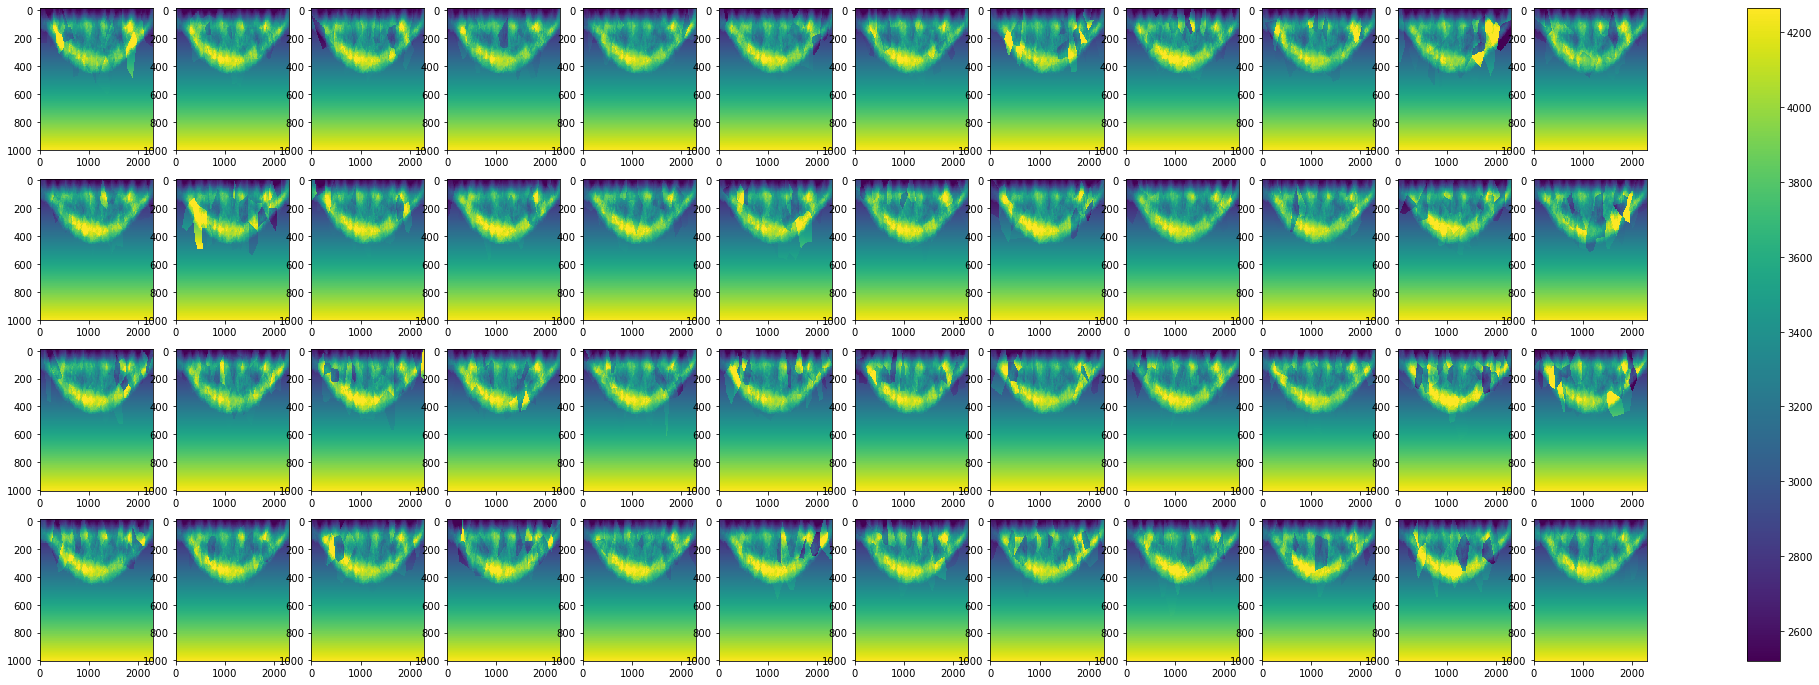

In [109]:
plt.close("all")
fig, axes = plt.subplots(figsize=(36, 12), nrows=4, ncols=12)

for vv, ax in zip(vvs, axes.flatten()):
    qmesh = ax.pcolormesh(
        vmodel.nodes[:, :, 0, 0], 
        vmodel.nodes[:, :, 0, 1], 
        vv[:, :, 0], 
        vmin=vmodel_true.values.min(), 
        vmax=vmodel_true.values.max()
    )
    ax.invert_yaxis()

fig.colorbar(qmesh, ax=axes.flatten())

In [118]:
%matplotlib ipympl

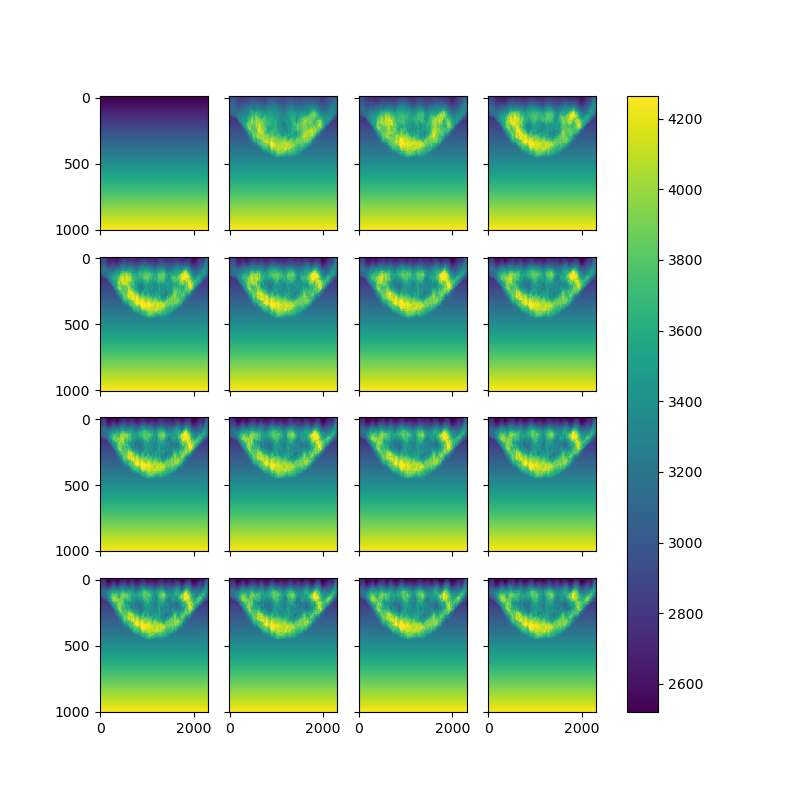

In [122]:
vv = np.median(np.stack(vvs), axis=0)

plt.close("all")
fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)

for model, ax in zip(models, axes.flatten()):
    qmesh = ax.pcolormesh(
        vmodel.nodes[:, :, 0, 0], 
        vmodel.nodes[:, :, 0, 1], 
        model[:, :, 0], 
        vmin=vmodel_true.values.min(), 
        vmax=vmodel_true.values.max()
    )
    ax.invert_yaxis()
fig.colorbar(qmesh, ax=axes.flatten())

for ax in axes[: -1].flatten():
    ax.set_xticklabels([])
    
for ax in axes[:, 1:].flatten():
    ax.set_yticklabels([])